In [1]:
from keras.models import load_model
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim

In [2]:
def generator_to_array(generator):
    # Initialiser une liste pour stocker les échantillons
    num_samples = len(generator)
    samples = []
    # Itérer sur le générateur pour obtenir les échantillons
    for i in range(num_samples):
        batch = generator.next()
        for image in batch[0]:
            samples.append(image)  # Ajouter uniquement les données (ignorer les étiquettes)
    return np.array(samples)

def mean_cosinus_similarity(v1, v2):
    cosinus_similarity = 0
    nb_individus = v1.shape[0]
    for i in range(nb_individus):
        cosinus_similarity += np.dot(v1[i], v2[i]) / (np.linalg.norm(v1[i]) * np.linalg.norm(v2[i]))
    return cosinus_similarity/nb_individus

def calculate_mean_dispersion(latent_representations):
    centroid = np.mean(latent_representations, axis=0)
    distance_squared = np.sum((latent_representations - centroid)**2, axis = 1)
    return np.mean(distance_squared)

def comparaison_visages(asian, asian_predict, white, white_predict, ethnie):

    plt.figure(figsize=(15, 6))

    # Affichage des images du premier trainset
    plt.subplot(2, 5, (1, 5))
    plt.axis("off")
    plt.title('Caucasiens')
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(white[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(white_predict[i], cmap='gray')
        plt.axis('off')

    # Titre global
    plt.suptitle(f'Comparaison des images d entrées et de sorties caucasiennes d espace latent {ethnie}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 6))

    # Affichage des images du premier trainset
    plt.subplot(2, 5, (1, 5))
    plt.axis("off")
    plt.title('Asiatiques')
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(asian[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(asian_predict[i], cmap='gray')
        plt.axis('off')

    # Titre global
    plt.suptitle('Comparaison des images d entrées et de sorties asiatiques')
    plt.tight_layout()
    plt.show()

def pca(latent_asian, latent_white, ethnie):
    pca = PCA(n_components=2)
    latent_pca_white = pca.fit_transform(latent_white)
    latent_pca_asian = pca.fit_transform(latent_asian)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_pca_white[:, 0], latent_pca_white[:, 1], color='r', alpha=0.5, label='white_predict')
    scatter_b = plt.scatter(latent_pca_asian[:, 0], latent_pca_asian[:, 1], color='b', alpha=0.5, label='asian_predict')
    plt.legend(handles=[scatter, scatter_b])
    plt.title(f'Projection ACP de l espace latent {ethnie}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    return np.concatenate([latent_pca_white, latent_pca_asian], axis=0)


def cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten):
    asian_cs = mean_cosinus_similarity(asian_flatten, asian_predict_flatten)
    white_cs = mean_cosinus_similarity(white_flatten, white_predict_flatten)
    print(f"Moyenne des similarités cosinus pour les individus caucasiens : {white_cs}")
    print(f"Moyenne des similarités cosinus pour les individus asiatiques : {asian_cs}")
    
def comparaison_dispersion(latent_asian, latent_white):
    asian_mean_dispersion = calculate_mean_dispersion(latent_asian)
    white_mean_dispersion = calculate_mean_dispersion(latent_white)
    print(f"Moyenne des dispersions des espaces latents pour les individus caucasiens : {white_mean_dispersion}")
    print(f"Moyenne des dispersions des espaces latents pour les individus asiatiques : {asian_mean_dispersion}")

def coef_bhattacharyya(latent_asian, latent_white):
    normalize_a = tf.nn.l2_normalize(np.mean(latent_asian, axis=0),axis=0)        
    normalize_b = tf.nn.l2_normalize(np.mean(latent_white, axis=0),axis=0)
    return tf.reduce_sum(tf.multiply(normalize_a,normalize_b))

def ssim_mean(ytrue, ypred, length):
    
    res = 0
    for i in range(length):
        res+=ssim(ytrue[i], ypred[i], data_range=ytrue[i].max() - ytrue[i].min(), multichannel=False)
    
    return res/length

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, dtype='float16')
datatrain_white = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    classes=['Caucasiens'],
    target_size=(150, 150),
    batch_size=64, 
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')

datatrain_east_asian = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    classes=['Asiatiques'],
    target_size=(150, 150),
    batch_size=64,
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')

datatest_white = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    classes=['Caucasiens'],
    target_size=(150, 150),
    batch_size=64, 
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')

datatest_east_asian = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    classes=['Asiatiques'],
    target_size=(150, 150),
    batch_size=64,
    class_mode='input',
    shuffle=True,
    color_mode='grayscale')

Found 50 images belonging to 1 classes.


Found 50 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


In [4]:
model = load_model('Modeles/STIM/stim_autoencoder_white_32.hdf5')

In [5]:
ethnie = 'white'
get_latent = keras.Model(inputs=model.input, outputs=model.get_layer('latent_space_layer_norm').output)
latent_asian = get_latent.predict(datatrain_east_asian)
latent_white = get_latent.predict(datatrain_white)

asian_predict = model.predict(datatrain_east_asian).reshape(50,150,150)
white_predict = model.predict(datatrain_white).reshape(50,150,150)
asian = generator_to_array(datatrain_east_asian).reshape(50,150,150)
white = generator_to_array(datatrain_white).reshape(50,150,150)

asian_predict_flatten = asian_predict.reshape(50, -1)
white_predict_flatten = white_predict.reshape(50, -1)
asian_flatten = asian.reshape(50, -1)
white_flatten = white.reshape(50, -1)

1/1 [==============================] - 0s 66ms/step


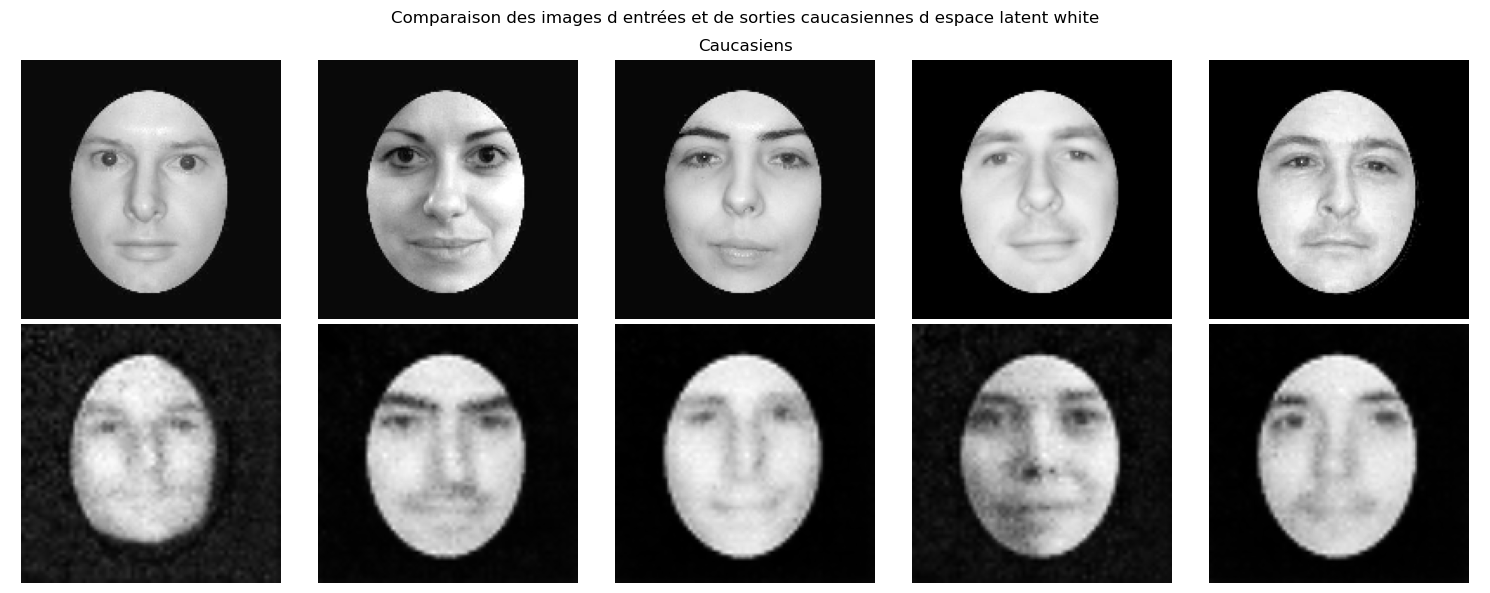

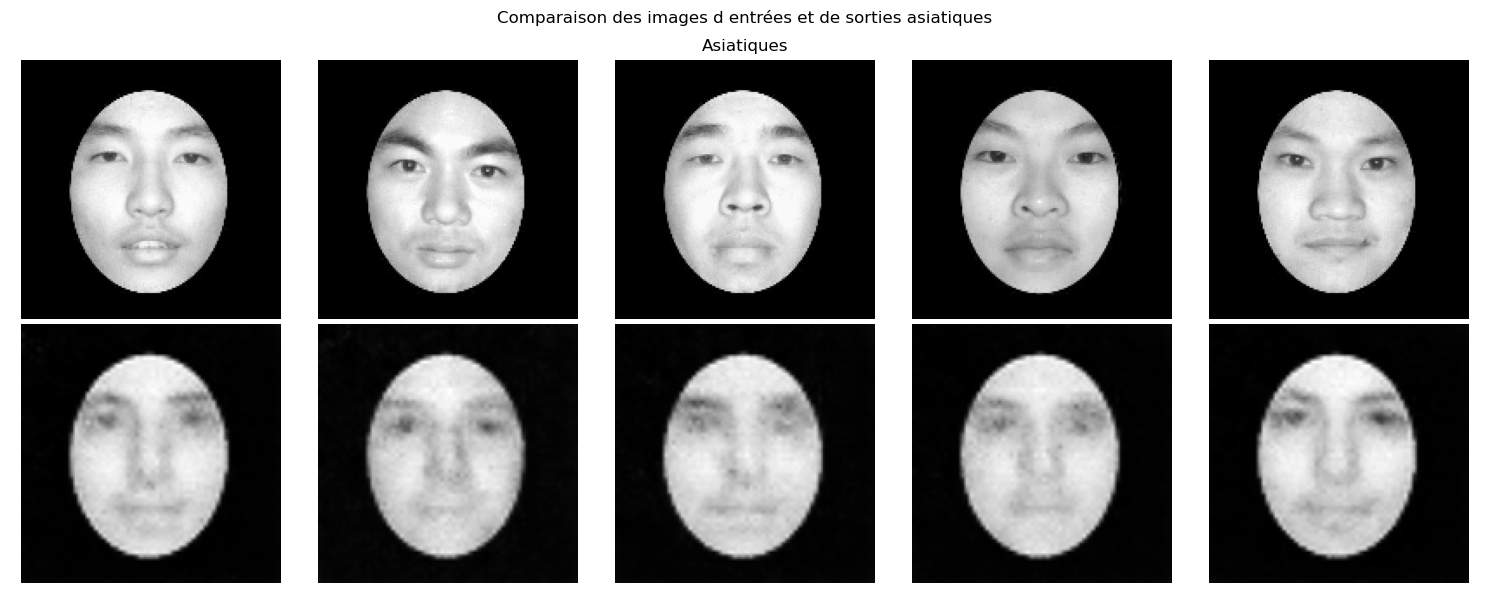

In [6]:
comparaison_visages(asian, asian_predict, white, white_predict, "white")

In [7]:
print(ssim_mean(asian, asian_predict, 50))
ssim_mean(white, white_predict, 50)

0.64107660613038


0.5275411141192954

In [9]:
ssim(asian, asian_predict, data_range=asian.max() - asian.min(), multichannel=False)

0.5807503203847898

In [8]:
ssim(white, white_predict, data_range=white.max() - white.min(), multichannel=False)

0.3723243598798288

In [129]:
A = np.zeros(shape=(150, 150))
B = np.ones(shape=(150, 150))
ssim(A, B)

9.999000099990002e-05

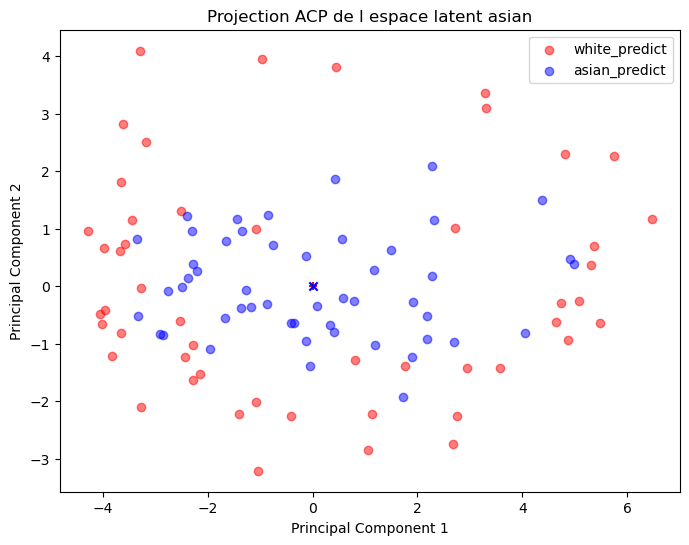

Moyenne des similarités cosinus pour les individus caucasiens : 0.9733147776126861
Moyenne des similarités cosinus pour les individus asiatiques : 0.9892653238773346
Moyenne des dispersions des espaces latents pour les individus caucasiens : 22.882841110229492
Moyenne des dispersions des espaces latents pour les individus asiatiques : 6.9635329246521


In [101]:
latent_pca = pca(latent_asian, latent_white, ethnie)
cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten)
comparaison_dispersion(latent_asian, latent_white)